In [ ]:
!sudo apt install libspatialindex-dev

In [ ]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

In [3]:
pip install osmnx

     |████████████████████████████████| 92kB 2.1MB/s 
     |████████████████████████████████| 10.9MB 7.9MB/s 
     |████████████████████████████████| 972kB 20.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 11.6MB 43.0MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 14.5MB 313kB/s 
     |████████████████████████████████| 14.8MB 253kB/s 
  Created wheel for Rtree: filename=Rtree-0.9.4-cp36-none-any.whl size=21767 sha256=a6a71e6531b94af7565beacce4cbf46af8d2333c52e91e70999be511e0df6bbe
  Stored in directory: /root/.cache/pip/wheels/ff/20/c5/0004ef7acb96745ec99be960053902b0b414a2aa2dcad5834e
Successfully built Rtree
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement foli

In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from accident import ACCIDENT

In [3]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

In [197]:
GC = ox.consolidate_intersections(ox.project_graph(G), 20)

In [198]:
nx.info(GC)

'Name: \nType: MultiDiGraph\nNumber of nodes: 20683\nNumber of edges: 60331\nAverage in degree:   2.9169\nAverage out degree:   2.9169'

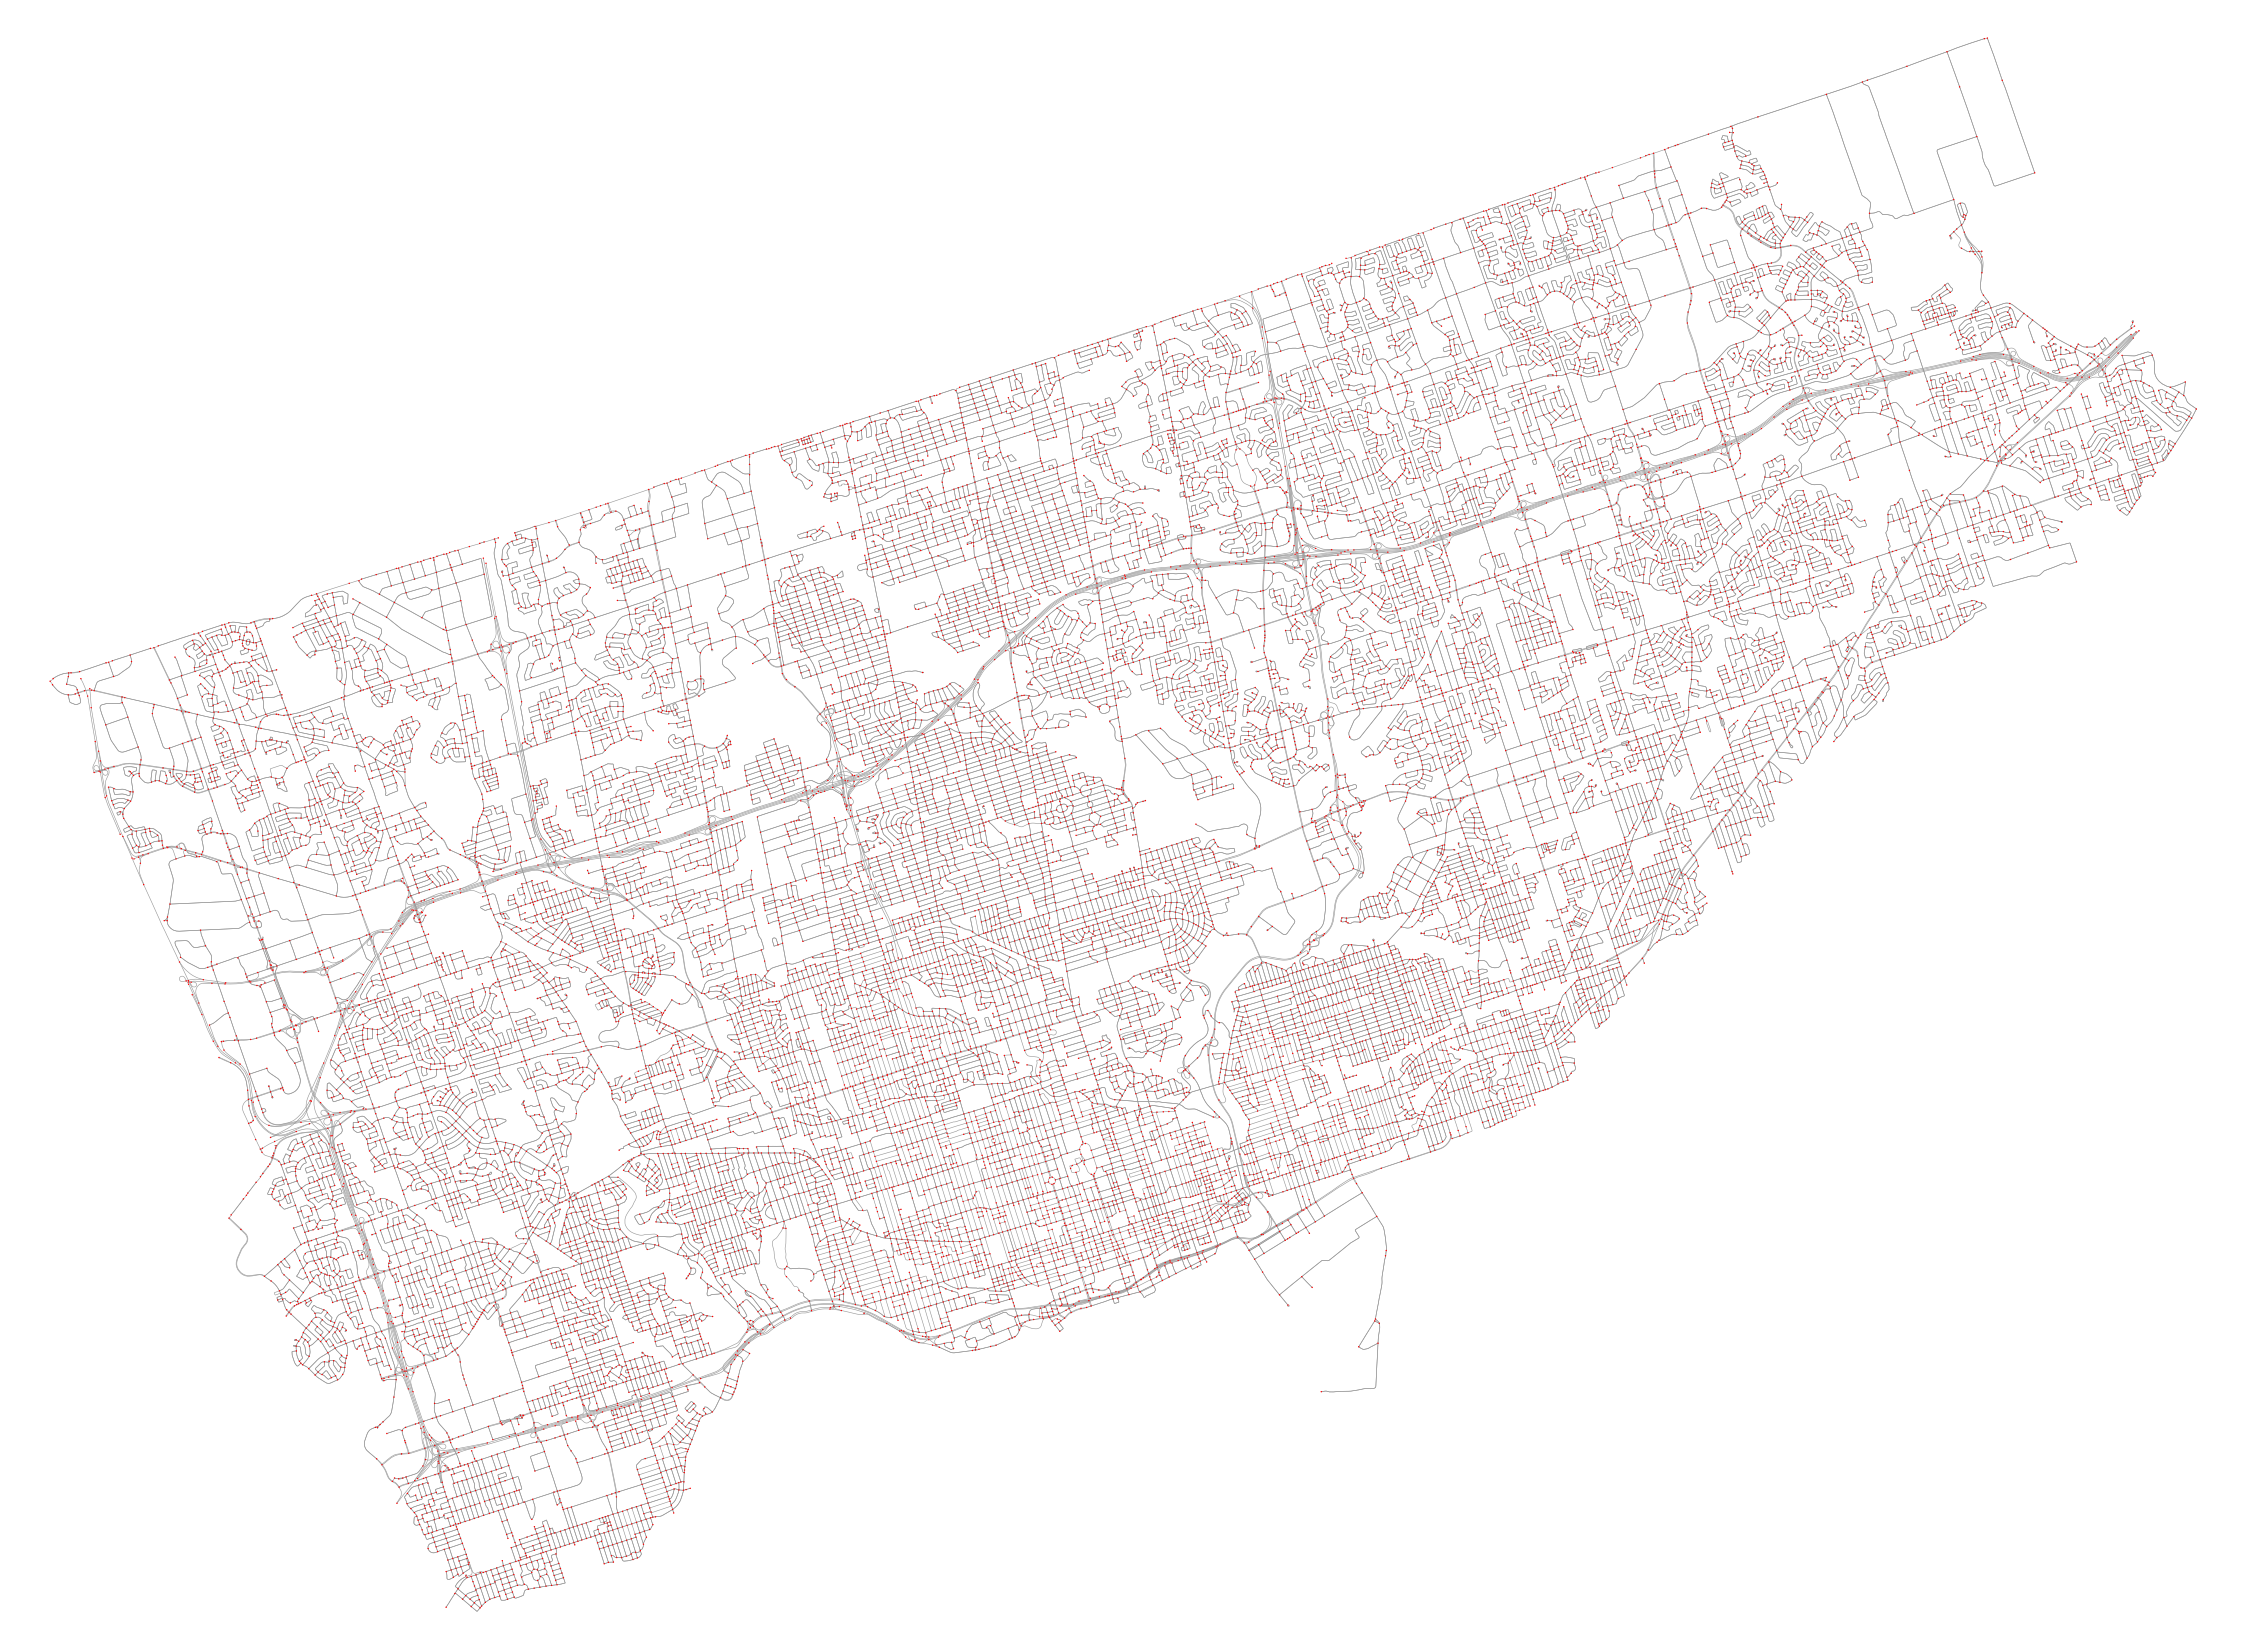

(<Figure size 2880x2880 with 1 Axes>, <AxesSubplot:>)

In [201]:
ox.plot_graph(GC, bgcolor='white', node_size=2, node_color="red", edge_linewidth=0.6, edge_alpha=1, dpi=1000, figsize=(40,40))

In [31]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27438
Number of edges: 73174
Average in degree:   2.6669
Average out degree:   2.6669


In [32]:
nodesG =  list(G.nodes.data())

In [33]:
nodesG[0]

(1497793,
 {'highway': 'motorway_junction',
  'osmid': 1497793,
  'ref': '14',
  'x': -79.3346901,
  'y': 43.7555309})

In [ ]:
edges =  list(G.edges.data())
edges[160][2]

In [175]:
nodes =  ox.graph_to_gdfs(GC, edges=False)

In [176]:
x_gc = nodes.lon.to_dict()
y_gc = nodes.lat.to_dict()

In [177]:
nx.set_node_attributes(GC,x_gc, 'x')
nx.set_node_attributes(GC,y_gc, 'y')

In [178]:
nodes_GC = GC.nodes()

In [179]:
nodes_GC[0]

{'lat': 43.5873289,
 'lon': -79.5478817,
 'osmid': 1610776610,
 'x': -79.5478817,
 'y': 43.5873289}

## KSI Dataset:

In [180]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [181]:
ksi_df.head()

,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,Division,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourhood,ObjectId,geometry
0,3389067,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,50 to 54,Major,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),1,POINT (-79.31880 43.69960)
1,3389068,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),2,POINT (-79.31880 43.69960)
2,3389069,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Driver,55 to 59,Minor,None,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),3,POINT (-79.31880 43.69960)
3,3389070,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,20 to 24,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),4,POINT (-79.31880 43.69960)
4,3389071,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),5,POINT (-79.31880 43.69960)


Combining Date and Hour to have one single column:

In [182]:
ksi_df["DATE"] = pd.to_datetime(ksi_df['DATE']).dt.floor("D") + pd.to_timedelta(ksi_df["HOUR"], unit="hour")

Add datapoints to keep here:

In [183]:
cols_to_keep = ["LATITUDE", "LONGITUDE", "ACCNUM", "DATE", "VISIBILITY", "LIGHT",	"RDSFCOND"]
ksi_df = ksi_df[cols_to_keep]

Counting fatalities using duplicate rows:

In [184]:
fatalities = ksi_df["ACCNUM"].value_counts()
ksi_df["FATALITIES"] = ksi_df["ACCNUM"].apply(lambda x : fatalities[x])

In [185]:
ksi_df = ksi_df.drop_duplicates()
ksi_df.reset_index(drop=True, inplace=True)

In [186]:
ksi_df["G_NODE"]= ox.get_nearest_nodes(GC, ksi_df["LONGITUDE"], ksi_df["LATITUDE"])
# ksi_df.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [187]:
ksi_df = ksi_df.infer_objects()
ksi_df

,LATITUDE,LONGITUDE,ACCNUM,DATE,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE
0,43.699595,-79.318797,893184,2006-01-01 02:00:00+00:00,Clear,Dark,Wet,8,2916
1,43.684874,-79.316188,909646,2006-01-01 03:00:00+00:00,Snow,"Dark, artificial",Slush,5,2334
2,43.652892,-79.406253,884090,2006-01-02 07:00:00+00:00,Other,"Dark, artificial",Wet,2,1090
3,43.655145,-79.433590,885782,2006-01-04 19:00:00+00:00,Rain,Dark,Wet,2,1111
4,43.777056,-79.347858,882079,2006-01-06 22:00:00+00:00,Clear,"Dark, artificial",Dry,2,6577
...,...,...,...,...,...,...,...,...,...
5685,43.678390,-79.464794,9002468442,2019-12-23 06:00:00+00:00,Clear,Dawn,Wet,2,2064
5686,43.660304,-79.517086,9002471073,2019-12-23 14:00:00+00:00,Clear,Daylight,Dry,3,1280
5687,43.775104,-79.347011,9002481518,2019-12-25 08:00:00+00:00,Clear,Daylight,Wet,2,6565-0
5688,43.752475,-79.516483,9002496688,2019-12-27 23:00:00+00:00,Clear,"Dark, artificial",Dry,2,5361


In [188]:
ksi_df.loc[ksi_df['ACCNUM'].isin(['893184', '1019180'])]

,LATITUDE,LONGITUDE,ACCNUM,DATE,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE
0,43.699595,-79.318797,893184,2006-01-01 02:00:00+00:00,Clear,Dark,Wet,8,2916
1250,43.700148,-79.319026,1019180,2008-02-04 12:00:00+00:00,Clear,Daylight,Dry,4,2916


In [189]:
len(set(ksi_df['G_NODE']))

1936

Creating column of accident objects:

In [190]:
ksi_df["ACCIDENT"] = ksi_df.apply(lambda x: ACCIDENT(x["ACCNUM"], x["DATE"], x["VISIBILITY"], x["LIGHT"], x["RDSFCOND"], x["FATALITIES"]), axis=1)

In [ ]:
ksi_df

Collapsing dataset to get list of accidents for each node:

In [191]:
ksi_df = ksi_df.groupby('G_NODE')['ACCIDENT'].apply(list).reset_index(name='ACCIDENTS')

In [ ]:
ksi_df

Converting dataset to dict to set node attributes:

In [192]:
attr = ksi_df.set_index('G_NODE')['ACCIDENTS'].to_dict()

In [193]:
nx.set_node_attributes(GC, [], "accident_list")
nx.set_node_attributes(GC, attr, "accident_list")

In [194]:
ksi_df

,G_NODE,ACCIDENTS
0,1000,"[ACCIDENT(acc_id='7000675895', date=Timestamp(..."
1,1003,"[ACCIDENT(acc_id='1038512', date=Timestamp('20..."
2,1008,"[ACCIDENT(acc_id='5001851224', date=Timestamp(..."
3,1010,"[ACCIDENT(acc_id='900242', date=Timestamp('200..."
4,1013,"[ACCIDENT(acc_id='1264528', date=Timestamp('20..."
...,...,...
1931,986,"[ACCIDENT(acc_id='1233009', date=Timestamp('20..."
1932,987,"[ACCIDENT(acc_id='945694', date=Timestamp('200..."
1933,991,"[ACCIDENT(acc_id='1083896', date=Timestamp('20..."
1934,992,"[ACCIDENT(acc_id='982264', date=Timestamp('200..."


Example Nodes:

In [196]:
GC.nodes[2916]

{'accident_list': [],
 'lat': 43.698856,
 'lon': -79.3171011,
 'osmid': 259196376,
 'x': -79.3171011,
 'y': 43.698856}

In [ ]:
G.nodes[158754118]

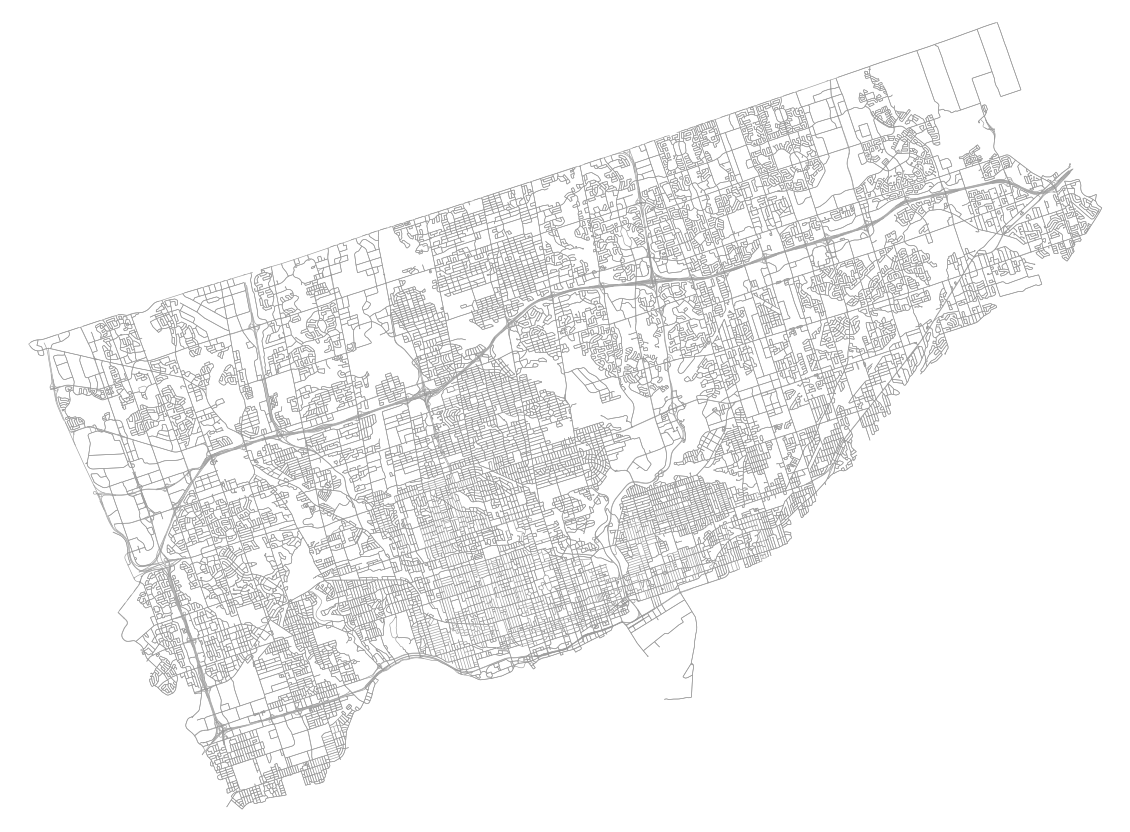

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [143]:
ox.plot_graph(GC, bgcolor='white', node_size=1, node_color="red", edge_linewidth=0.6, edge_alpha=1, dpi=1000, figsize=(20,20))